## Arizona Bike Stores Monthly Sales Prediction
This model predicts future monthly sales based on the previous month's sales, 3-months rolling average and month.

## Work Flow
1. Data Exploration (EDA)
2. Data Cleaning and Transformation
3. Feature Engineering
4. Pipeline, Model Tuning and Evaluation
5. Predictions

### 1. Data Exploration (EDA)

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Import sales data from 2022 to 2024
# create empty dataframe
df_sales = pd.DataFrame()

# retrieve files in sales folder and append to the dataframe
files = [file for file in os.listdir("dataset/Fact_Sales/")]
for file in files:
    fact_sales = pd.read_csv("dataset/Fact_Sales/"+file, parse_dates=['OrderDate'])
    df_sales = pd.concat([df_sales, fact_sales])

# Sort sales data by date
df_sales.sort_values(by='OrderDate', ascending=True, inplace=True)
df_sales.head()

,OrderDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity
0,2022-01-01,SO45080,332,14657,1,1,1
1,2022-01-01,SO45079,312,29255,4,1,1
2,2022-01-01,SO45082,350,11455,9,1,1
3,2022-01-01,SO45081,338,26782,6,1,1
4,2022-01-02,SO45083,312,14947,10,1,1


In [3]:
# Check the min and max order date to see if all the data is present
min(df_sales.OrderDate), max(df_sales.OrderDate)

(Timestamp('2022-01-01 00:00:00'), Timestamp('2024-06-30 00:00:00'))

In [4]:
# Check data types and nulls
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56046 entries, 0 to 29480
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   OrderDate      56046 non-null  datetime64[ns]
 1   OrderNumber    56046 non-null  object        
 2   ProductKey     56046 non-null  int64         
 3   CustomerKey    56046 non-null  int64         
 4   TerritoryKey   56046 non-null  int64         
 5   OrderLineItem  56046 non-null  int64         
 6   OrderQuantity  56046 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 3.4+ MB


In [5]:
# Import product's data to get the product price
df_products = pd.read_csv("dataset/Dim_Products.csv")
df_products.head(3)

,ProductKey,ProductSubcategoryKey,ProductSKU,ProductName,ModelName,ProductDescription,ProductColor,ProductSize,ProductStyle,ProductCost,ProductPrice
0,214,31,HL-U509-R,"Sport-100 Helmet, Red",Sport-100,"Universal fit, well-vented, lightweight , snap...",Red,0,0,13.0863,34.9900
1,215,31,HL-U509,"Sport-100 Helmet, Black",Sport-100,"Universal fit, well-vented, lightweight , snap...",Black,0,0,12.0278,33.6442
2,218,23,SO-B909-M,"Mountain Bike Socks, M",Mountain Bike Socks,Combination of natural and synthetic fibers st...,White,M,U,3.3963,9.5000


In [6]:
# Check for null values
df_products.isna().sum()

ProductKey                0
ProductSubcategoryKey     0
ProductSKU                0
ProductName               0
ModelName                 0
ProductDescription        0
ProductColor             50
ProductSize               0
ProductStyle              0
ProductCost               0
ProductPrice              0
dtype: int64

### 2. Data Cleaning and Transformation

In [7]:
# Join both dataframes to get the sales
sales_products = pd.merge(df_sales, df_products, on='ProductKey', how='left')
sales_products.head(3)

,OrderDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,ProductSubcategoryKey,ProductSKU,ProductName,ModelName,ProductDescription,ProductColor,ProductSize,ProductStyle,ProductCost,ProductPrice
0,2022-01-01,SO45080,332,14657,1,1,1,2,BK-R50B-58,"Road-650 Black, 58",Road-650,Value-priced bike with many features of our to...,Black,58,U,413.1463,699.0982
1,2022-01-01,SO45079,312,29255,4,1,1,2,BK-R93R-48,"Road-150 Red, 48",Road-150,This bike is ridden by race winners. Developed...,Red,48,U,2171.2942,3578.2700
2,2022-01-01,SO45082,350,11455,9,1,1,1,BK-M82B-44,"Mountain-100 Black, 44",Mountain-100,Top-of-the-line competition mountain bike. Per...,Black,44,U,1898.0944,3374.9900


In [8]:
# Calculate sales
sales_products['Sales'] = sales_products['OrderQuantity'] * sales_products['ProductPrice']

# Select needed features
sales_data = sales_products[['OrderDate','Sales']].sort_values(by='OrderDate', ascending=True)

# Create last day of the month column to aggregate sales by month
sales_data["month_date"] = sales_data["OrderDate"] + pd.offsets.MonthEnd(0)
sales_data.head()

,OrderDate,Sales,month_date
0,2022-01-01,699.0982,2022-01-31
1,2022-01-01,3578.2700,2022-01-31
2,2022-01-01,3374.9900,2022-01-31
3,2022-01-01,699.0982,2022-01-31
4,2022-01-02,3578.2700,2022-01-31


In [9]:
# Aggregate sales to month
monthly_sales = sales_data.groupby(['month_date'])['Sales'].sum().to_frame('total_sales')
monthly_sales.head()

,total_sales
month_date,
2022-01-31,585312.6486
2022-02-28,532226.2458
2022-03-31,643436.1040
2022-04-30,653364.0368
2022-05-31,659325.8968


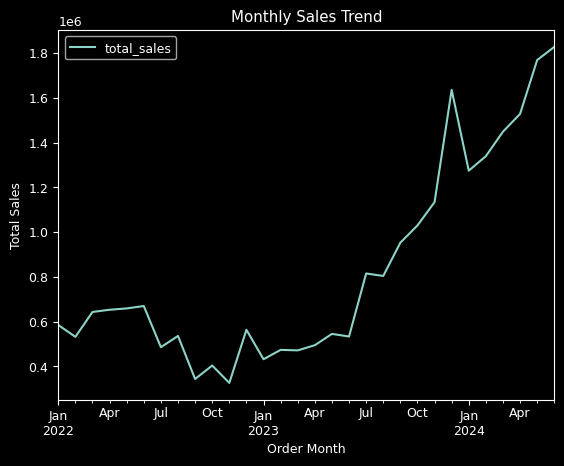

In [10]:
# Visualize the data
plt.style.use('dark_background')
plt.rcParams.update({'font.size':9})
ax = monthly_sales.plot()
ax.set(title="Monthly Sales Trend", xlabel="Order Month", ylabel="Total Sales" )
plt.show()

### 3. Feature Engineering

In [11]:
# Get previous month sales feature
monthly_sales['prev_month_sales'] = monthly_sales['total_sales'].shift(1)
monthly_sales['prev_month_sales_2'] = monthly_sales['total_sales'].shift(2)
monthly_sales['prev_month_sales_3'] = monthly_sales['total_sales'].shift(3)

# Add a 3-month rolling average feature
monthly_sales['rolling_avg_3'] = monthly_sales['total_sales'].rolling(window=3).mean()

# Get previous 3 month rolling avg
monthly_sales['prev_rolling_avg_3'] = monthly_sales['rolling_avg_3'].shift(1)

# Add seasonality 
monthly_sales['month'] = monthly_sales.index.month

# drop null values
monthly_sales.dropna(inplace=True) # first 3 months have nulls and would be dropped

monthly_sales

,total_sales,prev_month_sales,prev_month_sales_2,prev_month_sales_3,rolling_avg_3,prev_rolling_avg_3,month
month_date,,,,,,,
2022-04-30,6.533640e+05,6.434361e+05,5.322262e+05,5.853126e+05,6.096755e+05,5.869917e+05,4
2022-05-31,6.593259e+05,6.533640e+05,6.434361e+05,5.322262e+05,6.520420e+05,6.096755e+05,5
2022-06-30,6.699887e+05,6.593259e+05,6.533640e+05,6.434361e+05,6.608929e+05,6.520420e+05,6
2022-07-31,4.861150e+05,6.699887e+05,6.593259e+05,6.533640e+05,6.051432e+05,6.608929e+05,7
2022-08-31,5.364528e+05,4.861150e+05,6.699887e+05,6.593259e+05,5.641855e+05,6.051432e+05,8
2022-09-30,3.440629e+05,5.364528e+05,4.861150e+05,6.699887e+05,4.555436e+05,5.641855e+05,9
2022-10-31,4.042766e+05,3.440629e+05,5.364528e+05,4.861150e+05,4.282641e+05,4.555436e+05,10
2022-11-30,3.266112e+05,4.042766e+05,3.440629e+05,5.364528e+05,3.583169e+05,4.282641e+05,11
2022-12-31,5.637615e+05,3.266112e+05,4.042766e+05,3.440629e+05,4.315498e+05,3.583169e+05,12


### 4. Pipeline, Model Tuning and Evaluation
We would test linear and random forest regression models, to see which is better.

In [12]:
# Import needed packages
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import pickle

# maintain same results
np.random.seed(42)

# split the data into features and label. 
X = monthly_sales.drop(['total_sales','rolling_avg_3'], axis=1) # We would be using the prev month sales and rolling avg
y = monthly_sales['total_sales']

# split the data train and test using sequential split
split_date = '2024-04-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = monthly_sales[:split_date]['total_sales'], monthly_sales[split_date:]['total_sales'] # test the last quarter

# Define the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Polynomial feature transformation
    ('scaler', StandardScaler()),    # Feature scaling
    ('linear', LinearRegression())   # Linear regression model
])

# Define the hyperparameter grid
param_grid = {
    'poly__degree': [1, 2, 3],  # Polynomial degrees to consider
    'poly__interaction_only': [False, True],  # Whether to include only interaction features
    'poly__include_bias': [False, True]  # Whether to include a bias term
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Predict on the test set
y_preds = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_preds)
mae = mean_absolute_error(y_test, y_preds)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

# Save the model
pickle.dump(grid_search.best_estimator_, open('model/sales_prediction-linear.pkl','wb'))

Best hyperparameters: {'poly__degree': 1, 'poly__include_bias': True, 'poly__interaction_only': False}
Mean Squared Error: 11970963472.554382
Mean Absolute Error: 85035.92417307042
Root Mean Squared Error: 109411.89822205984


In [13]:
# Set results to 2 decimal places for clcarity
pd.set_option('display.float_format', lambda x: '%.2f' %x)

# Compare actual sales vs predicted sales in a dataframe
result = pd.DataFrame(X_test)
result['Predicted_Sales'] = y_preds
result['Actual_Sales'] = y_test
result['diff'] = abs(result['Predicted_Sales'] - result['Actual_Sales']) 
result.sort_values(by='month_date', ascending=True, inplace=True)
result

,prev_month_sales,prev_month_sales_2,prev_month_sales_3,prev_rolling_avg_3,month,Predicted_Sales,Actual_Sales,diff
month_date,,,,,,,,
2024-04-30,1448596.12,1339241.29,1274378.67,1354072.03,4,1467395.21,1527813.72,60418.51
2024-05-31,1527813.72,1448596.12,1339241.29,1438550.38,5,1589508.04,1768432.51,178924.47
2024-06-30,1768432.51,1527813.72,1448596.12,1581614.12,6,1811222.34,1826987.14,15764.79


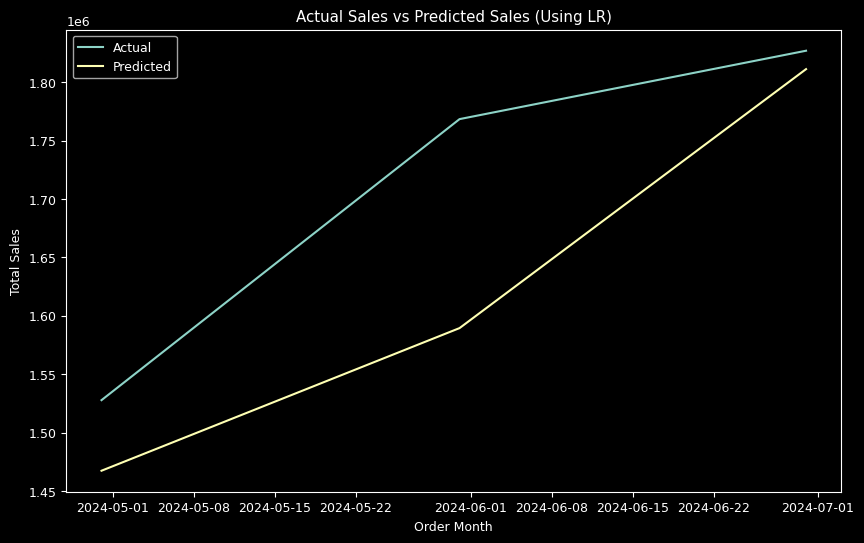

In [14]:
# visualize the result
plt.figure(figsize=(10,6))
plt.plot(result['Actual_Sales'], label='Actual')
plt.plot(result['Predicted_Sales'], label='Predicted')
plt.title("Actual Sales vs Predicted Sales (Using LR)")
plt.ylabel("Total Sales")
plt.xlabel("Order Month")
plt.legend()
plt.show()

### 5. Prediction - make prediction for next month

We would use the last month sales and average sales for the last 3months to predict the next month sales

In [15]:
monthly_sales.head(3)

,total_sales,prev_month_sales,prev_month_sales_2,prev_month_sales_3,rolling_avg_3,prev_rolling_avg_3,month
month_date,,,,,,,
2022-04-30,653364.04,643436.10,532226.25,585312.65,609675.46,586991.67,4
2022-05-31,659325.90,653364.04,643436.10,532226.25,652042.01,609675.46,5
2022-06-30,669988.67,659325.90,653364.04,643436.10,660892.87,652042.01,6


In [16]:
# Get the data for the current month sales
current_sales = monthly_sales.iloc[-1]['total_sales']
prev_month_sales_1 = monthly_sales.iloc[-2]['total_sales']
prev_month_sales_2 = monthly_sales.iloc[-3]['total_sales']
month_3_rolling_avg = monthly_sales.iloc[-1]['rolling_avg_3']
month_num = monthly_sales.iloc[-1]['month'] + 1

# get next month date for dataframe
next_month = monthly_sales.index[-1]+ pd.DateOffset(months=1)

# Display in a dataframe for clarity
data = pd.DataFrame({"prev_month_sales": [current_sales], 
                     "prev_month_sales_2": [prev_month_sales_1],
                     "prev_month_sales_3": [prev_month_sales_2],
                    "prev_rolling_avg_3": [month_3_rolling_avg],
                    "month": [month_num]}, 
                             index = [next_month] )
data

,prev_month_sales,prev_month_sales_2,prev_month_sales_3,prev_rolling_avg_3,month
2024-07-30,1826987.14,1768432.51,1527813.72,1707744.45,7.00


In [17]:
# Predict the sales for the next month (July 2024)
model = pickle.load(open("model/sales_prediction-linear.pkl","rb"))
next_month_prediction = model.predict(data)

# put it in a dataframe
prediction_df = pd.DataFrame()
prediction_df['total_sales'] = [next_month_prediction[0]]
prediction_df['month_date'] = [monthly_sales.index[-1] + pd.DateOffset(months=1)]
prediction_df.set_index('month_date', inplace=True)
prediction_df

,total_sales
month_date,
2024-07-30,1974092.78


`We can run predictions for multiple months, using a for loop.`

In [18]:
# Save the monthly sale df to use for testing in production
monthly_sales.to_csv("monthly_sales.csv")